In [1]:
#### Imports

from pandas import read_csv
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
# load the new file
ds = pd.read_csv('data_for_interview.csv', index_col=0)

In [3]:
# we observed that dates 23 and 24 are perfect for training our model (they have no missing data)
chosen_dates = ['2020-06-23', '2020-06-24']

In [4]:
# first we analyze the data
i = 1

# make train and test datasets from the chosen dates
ds_train = ds[ds['Datetime'].str.contains('|'.join(chosen_dates)) & ds['device'].str.contains(str(i))]
ds_test = ds[ds['Datetime'].str.contains('2020-06-25') & ds['device'].str.contains(str(i))]


# take the objective column
ds_train = ds_train['DissolvedOxygen'] # 48 hours data as train
ds_test = ds_test['DissolvedOxygen'][:6] # we need the first 6 hours

# fit ARIMA model
model = ARIMA(ds_train, order=(6,1,0))
model_fit = model.fit()

NameError: name 'i' is not defined

In [27]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        DissolvedOxygen   No. Observations:                   48
Model:                 ARIMA(6, 1, 0)   Log Likelihood                -133.162
Date:                Fri, 11 Dec 2020   AIC                            280.324
Time:                        03:05:39   BIC                            293.275
Sample:                             0   HQIC                           285.197
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2419      0.188     -1.289      0.197      -0.610       0.126
ar.L2         -0.4106      0.168     -2.442      0.015      -0.740      -0.081
ar.L3         -0.1514      0.219     -0.691      0.4

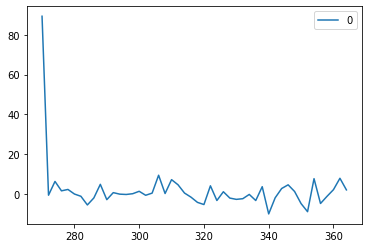

In [28]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

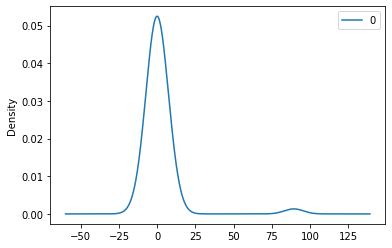

In [29]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

### bias
The results show that there is no bias in the prediction (zero mean is residual error).
if there is error, then we have to differencite the time series

# Rolling Forecast ARIMA Model
We forecast the next step. Then, this value will be added to the train and we make another model to forecast the next step. This will continue until the number of needed forecast reach. 

In [54]:
# for each device we do the forecasting seperately
n_hours = 6 # number of hours that we are going to forecast
forecast_list = []
test_list = []

for i in range(1,6): # we have 5 devices (1 to 5)
    
    # make train and test datasets from the chosen dates
    ds_train = ds[ds['Datetime'].str.contains('|'.join(chosen_dates)) & ds['device'].str.contains(str(i))]
    ds_test = ds[ds['Datetime'].str.contains('2020-06-25') & ds['device'].str.contains(str(i))]

    
    # take the objective column
    ds_train = ds_train['DissolvedOxygen'].values # 48 hours data as train
    ds_test = ds_test['DissolvedOxygen'][:n_hours].values # we need the first 6 hours
    
    # making the historical time series
    history = [x for x in ds_train]
    predictions = list()
    
    # walk-forward validation
    for h in range(len(ds_test)):
        model = ARIMA(history, order=(6,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        y = output[0]
        predictions.append(y)
        
        ### obs = ds_test[h] # sometimes we can add the test value in our history
                
        history.append(y)
        # print('predicted=%f, expected=%f' % (y, ds_test[h]))
    
    forecast_list.append(predictions)
    test_list.append(ds_test)

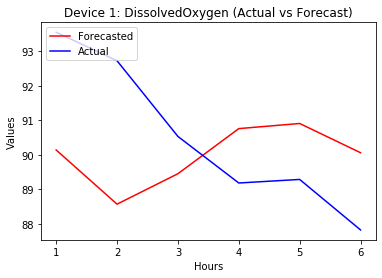

MSE:  6.702931937602624
RMSE:  2.5890021123210047


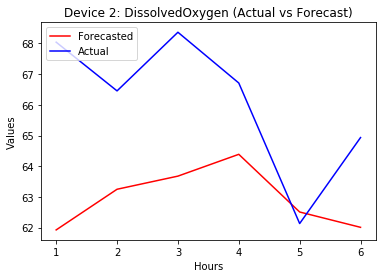

MSE:  13.947003642674352
RMSE:  3.7345687358347486


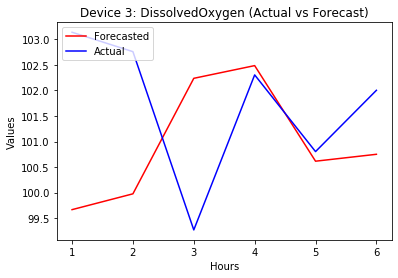

MSE:  5.04268653148934
RMSE:  2.2455926904693424


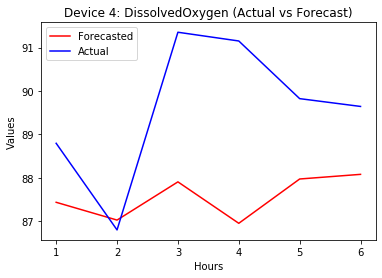

MSE:  6.23287944081673
RMSE:  2.4965735400377715


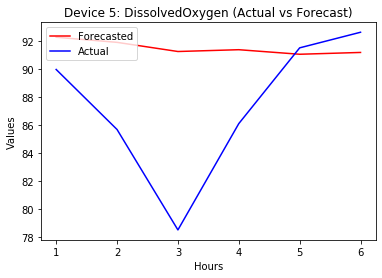

MSE:  39.43710454631201
RMSE:  6.279896857935806


In [59]:
# Plotting the Actual vs Forecasted for each device
for i in range(0,5):

    plt.plot(forecast_list[i], color='r', label='Forecasted')
    plt.plot(test_list[i], color='b', label='Actual')
    plt.title('Device '+ str(i+1) +': DissolvedOxygen (Actual vs Forecast)')
    plt.xlabel("Hours")
    plt.ylabel("Values")
    plt.xticks(range(0,6), range(1,7))
    plt.legend(loc="upper left")
    plt.show()
    
    # MSE
    
    mse = mean_squared_error(test_list[i], forecast_list[i])
    rmse = mse**(1/2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)